In [10]:
import pandas as pd
import numpy as np

# Load dataset
file_path = "/home/maria/CrimeStats/data/avalik_1(1).csv"
dat = pd.read_csv(file_path, sep='\t', encoding='utf-8')

# Filter Tallinn
tallinn = dat[dat['ValdLinnNimetus'] == 'Tallinn'].copy()

# Parse datetime
tallinn['ToimKpv'] = pd.to_datetime(tallinn['ToimKpv'], errors='coerce')
tallinn['ToimKell'] = tallinn['ToimKell'].fillna('00:00')
tallinn['ToimKell'] = pd.to_timedelta(tallinn['ToimKell'] + ':00')

tallinn['ToimDatetime'] = tallinn['ToimKpv'] + tallinn['ToimKell']
tallinn = tallinn.dropna(subset=['ToimDatetime'])

# Clean crime types
tallinn['SyndmusLiik'] = (
    tallinn['SyndmusLiik']
    .fillna('')
    .astype(str)
    .str.strip()
    .str.upper()
)

# Split multiple crime types
tallinn_expanded = tallinn.assign(
    SyndmusLiik=tallinn['SyndmusLiik'].str.split(',')
).explode('SyndmusLiik')

tallinn_expanded['SyndmusLiik'] = tallinn_expanded['SyndmusLiik'].str.strip()
tallinn_expanded = tallinn_expanded[tallinn_expanded['SyndmusLiik'] != '']

# ----------------------------------------
# EXTRACT INTER-ARRIVAL TIMES
# ----------------------------------------

results = []

for crime_type, group in tallinn_expanded.groupby('SyndmusLiik'):

    # Sort by time
    group = group.sort_values('ToimDatetime')

    # Compute inter-arrival times in hours
    inter_arrivals = group['ToimDatetime'].diff().dropna()
    inter_arrivals_hours = inter_arrivals.dt.total_seconds() / 3600

    # Skip small samples
    if len(inter_arrivals_hours) < 10:
        continue

    # Method of moments estimator
    mean_wait = inter_arrivals_hours.mean()
    lambda_hat = 1 / mean_wait

    results.append({
        "crime_type": crime_type,
        "n_events": len(group),
        "mean_wait_hours": mean_wait,
        "lambda_hat_per_hour": lambda_hat
    })

exp_fit = pd.DataFrame(results).sort_values("lambda_hat_per_hour", ascending=False)

exp_fit.head()


,crime_type,n_events,mean_wait_hours,lambda_hat_per_hour
13,VARGUS,3197,3.796866,0.263375
9,PISIVARGUS,1861,6.523674,0.153288
12,VANDALISM,527,23.037041,0.043408
1,JALGRATTA_MOPEEDI_VARGUS,284,41.312309,0.024206
0,AVALIKU_KORRA_RIKKUMINE,247,49.244648,0.020307


In [11]:
for a in exp_fit.iterrows():
    print(a)

(13, crime_type               VARGUS
n_events                   3197
mean_wait_hours        3.796866
lambda_hat_per_hour    0.263375
Name: 13, dtype: object)
(9, crime_type             PISIVARGUS
n_events                     1861
mean_wait_hours          6.523674
lambda_hat_per_hour      0.153288
Name: 9, dtype: object)
(12, crime_type             VANDALISM
n_events                     527
mean_wait_hours        23.037041
lambda_hat_per_hour     0.043408
Name: 12, dtype: object)
(1, crime_type             JALGRATTA_MOPEEDI_VARGUS
n_events                                    284
mean_wait_hours                       41.312309
lambda_hat_per_hour                    0.024206
Name: 1, dtype: object)
(0, crime_type             AVALIKU_KORRA_RIKKUMINE
n_events                                   247
mean_wait_hours                      49.244648
lambda_hat_per_hour                   0.020307
Name: 0, dtype: object)
(6, crime_type                LITTER
n_events                     121
mean_wait_

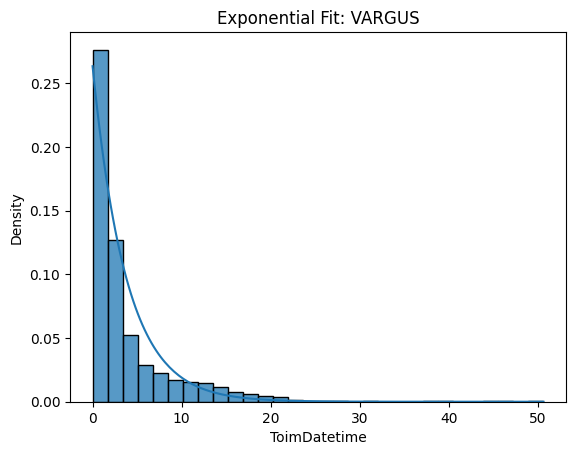

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

crime = exp_fit.iloc[0]["crime_type"]

group = tallinn_expanded[tallinn_expanded['SyndmusLiik'] == crime]
group = group.sort_values('ToimDatetime')

inter_arrivals = group['ToimDatetime'].diff().dropna()
inter_arrivals_hours = inter_arrivals.dt.total_seconds() / 3600

lambda_hat = 1 / inter_arrivals_hours.mean()

sns.histplot(inter_arrivals_hours, stat="density", bins=30)
x = np.linspace(0, inter_arrivals_hours.max(), 200)
plt.plot(x, lambda_hat * np.exp(-lambda_hat * x))
plt.title(f"Exponential Fit: {crime}")
plt.show()


/tmp/ipykernel_4172661/1632894337.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t_min = tallinn_expanded['ToimDatetime'].min().floor(bin_freq)
/tmp/ipykernel_4172661/1632894337.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t_max = tallinn_expanded['ToimDatetime'].max().ceil(bin_freq)
/tmp/ipykernel_4172661/1632894337.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_grid = pd.date_range(start=t_min, end=t_max, freq=bin_freq)
/tmp/ipykernel_4172661/1632894337.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample(bin_freq)
/tmp/ipykernel_4172661/1632894337.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample(bin_freq)


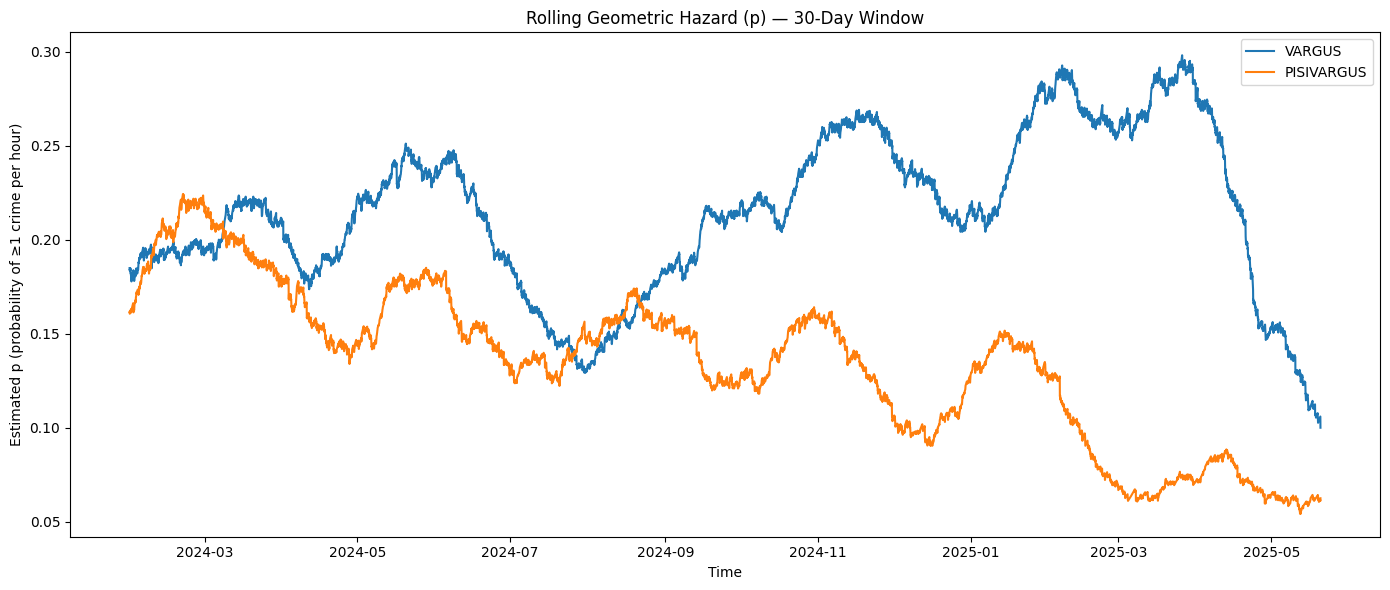

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# PARAMETERS
# ----------------------------
bin_freq = "H"          # discrete time resolution
window_days = 30
window_hours = 24 * window_days

selected_crimes = [
    "VARGUS", 
    "PISIVARGUS"
]

# ----------------------------
# CREATE GLOBAL HOURLY GRID
# ----------------------------
t_min = tallinn_expanded['ToimDatetime'].min().floor(bin_freq)
t_max = tallinn_expanded['ToimDatetime'].max().ceil(bin_freq)

hourly_grid = pd.date_range(start=t_min, end=t_max, freq=bin_freq)

# ----------------------------
# FUNCTION: Estimate rolling p
# ----------------------------
def rolling_geometric_p(group):

    group = group.sort_values("ToimDatetime")

    counts = (
        group
        .set_index("ToimDatetime")
        .resample(bin_freq)
        .size()
        .reindex(hourly_grid, fill_value=0)
    )

    bernoulli = (counts > 0).astype(int)

    p_series = []

    for i in range(len(bernoulli)):

        if i < window_hours:
            p_series.append(np.nan)
            continue

        window_data = bernoulli.iloc[i-window_hours:i]

        # extract waiting times
        waiting_times = []
        counter = 0

        for x in window_data:
            if x == 0:
                counter += 1
            else:
                waiting_times.append(counter + 1)
                counter = 0

        if len(waiting_times) == 0:
            p_series.append(np.nan)
        else:
            mean_wait = np.mean(waiting_times)
            p_hat = 1 / mean_wait
            p_series.append(p_hat)

    return pd.Series(p_series, index=hourly_grid)

# ----------------------------
# PLOT
# ----------------------------
plt.figure(figsize=(14,6))

for crime_type in selected_crimes:
    if crime_type not in tallinn_expanded['SyndmusLiik'].unique():
        continue
    
    group = tallinn_expanded[
        tallinn_expanded['SyndmusLiik'] == crime_type
    ]

    p_series = rolling_geometric_p(group)
    plt.plot(p_series.index, p_series, label=crime_type)

plt.title(f"Rolling Geometric Hazard (p) — {window_days}-Day Window")
plt.ylabel("Estimated p (probability of ≥1 crime per hour)")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
import numpy as np
import pandas as pd

# ============================
# PARAMETERS
# ============================

A = "PISIVARGUS"
B = "VARGUS"
window = pd.Timedelta("24H")
M_baseline = 5000  # number of random windows for baseline

# ============================
# PREP DATA
# ============================

df = tallinn_expanded.dropna(subset=["ToimDatetime"]).copy()
df = df.sort_values("ToimDatetime")

tA = df.loc[df["SyndmusLiik"] == A, "ToimDatetime"].to_numpy(dtype="datetime64[ns]")
tB = df.loc[df["SyndmusLiik"] == B, "ToimDatetime"].to_numpy(dtype="datetime64[ns]")

t_min = np.datetime64(df["ToimDatetime"].min())
t_max = np.datetime64(df["ToimDatetime"].max())
window_np = np.timedelta64(window)

# ============================
# 1️⃣ FORWARD CONDITIONAL
# ============================

valid_mask_forward = tA <= (t_max - window_np)
tA_valid = tA[valid_mask_forward]

left = np.searchsorted(tB, tA_valid, side="right")
right = np.searchsorted(tB, tA_valid + window_np, side="right")
hits_forward = (right > left)

p_forward = hits_forward.mean() if len(hits_forward) else np.nan
n_forward = len(hits_forward)

# standard error
se_forward = np.sqrt(p_forward * (1 - p_forward) / n_forward) if n_forward > 0 else np.nan

# ============================
# 2️⃣ BACKWARD CONDITIONAL
# ============================

valid_mask_backward = tB >= (t_min + window_np)
tB_valid = tB[valid_mask_backward]

left = np.searchsorted(tA, tB_valid - window_np, side="left")
right = np.searchsorted(tA, tB_valid, side="left")
hits_backward = (right > left)

p_backward = hits_backward.mean() if len(hits_backward) else np.nan
n_backward = len(hits_backward)

se_backward = np.sqrt(p_backward * (1 - p_backward) / n_backward) if n_backward > 0 else np.nan

# ============================
# 3️⃣ BASELINE PROBABILITY
# ============================

rng = np.random.default_rng(0)

latest_start = t_max - window_np

start_int = t_min.astype("datetime64[ns]").astype("int64")
end_int = latest_start.astype("datetime64[ns]").astype("int64")

starts = rng.integers(start_int, end_int + 1, size=M_baseline)
starts = starts.astype("datetime64[ns]")

left = np.searchsorted(tB, starts, side="left")
right = np.searchsorted(tB, starts + window_np, side="right")
hits0 = (right > left)

p0 = hits0.mean()
se0 = np.sqrt(p0 * (1 - p0) / M_baseline)

# ============================
# 4️⃣ LIFT
# ============================

lift = p_forward / p0 if p0 > 0 else np.nan

# ============================
# PRINT RESULTS
# ============================

print("\n================ RESULTS ================\n")

print(f"Forward conditional:")
print(f"P(≥1 {B} in next 24h | {A}) = {p_forward:.4f}")
print(f"SE = {se_forward:.4f}")
print(f"95% CI = [{p_forward - 1.96*se_forward:.4f}, {p_forward + 1.96*se_forward:.4f}]")
print(f"n = {n_forward}\n")

print(f"Backward conditional:")
print(f"P(≥1 {A} in prev 24h | {B}) = {p_backward:.4f}")
print(f"SE = {se_backward:.4f}")
print(f"95% CI = [{p_backward - 1.96*se_backward:.4f}, {p_backward + 1.96*se_backward:.4f}]")
print(f"n = {n_backward}\n")

print(f"Baseline probability:")
print(f"P(≥1 {B} in random 24h window) = {p0:.4f}")
print(f"SE = {se0:.4f}")
print(f"95% CI = [{p0 - 1.96*se0:.4f}, {p0 + 1.96*se0:.4f}]\n")

print(f"Lift (forward / baseline) = {lift:.3f}")

print("\n=========================================\n")


================ RESULTS ================

Forward conditional:
P(≥1 VARGUS in next 24h | PISIVARGUS) = 0.9925
SE = 0.0020
95% CI = [0.9885, 0.9964]
n = 1859

Backward conditional:
P(≥1 PISIVARGUS in prev 24h | VARGUS) = 0.9426
SE = 0.0041
95% CI = [0.9345, 0.9507]
n = 3189

Baseline probability:
P(≥1 VARGUS in random 24h window) = 0.9874
SE = 0.0016
95% CI = [0.9843, 0.9905]

Lift (forward / baseline) = 1.005




/tmp/ipykernel_4172661/3606393107.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window = pd.Timedelta("24H")


In [18]:
import numpy as np
import pandas as pd

# ============================
# PARAMETERS
# ============================

A = "PISIVARGUS"
B = "VARGUS"
window = pd.Timedelta("1h")  # lowercase h avoids warning
M_baseline = 10000

# ============================
# PREP DATA
# ============================

df = tallinn_expanded.dropna(subset=["ToimDatetime"]).copy()
df = df.sort_values("ToimDatetime")

tA = df.loc[df["SyndmusLiik"] == A, "ToimDatetime"].to_numpy(dtype="datetime64[ns]")
tB = df.loc[df["SyndmusLiik"] == B, "ToimDatetime"].to_numpy(dtype="datetime64[ns]")

t_min = np.datetime64(df["ToimDatetime"].min())
t_max = np.datetime64(df["ToimDatetime"].max())
window_np = np.timedelta64(window)

# ============================
# 1️⃣ CONDITIONAL PROBABILITY
# ============================

valid_mask = tA <= (t_max - window_np)
tA_valid = tA[valid_mask]

left = np.searchsorted(tB, tA_valid, side="right")
right = np.searchsorted(tB, tA_valid + window_np, side="right")
hits_cond = (right > left)

p_cond = hits_cond.mean()
n_cond = len(hits_cond)
se_cond = np.sqrt(p_cond * (1 - p_cond) / n_cond)

# ============================
# 2️⃣ UNCONDITIONAL PROBABILITY
# ============================

rng = np.random.default_rng(0)

latest_start = t_max - window_np

start_int = t_min.astype("datetime64[ns]").astype("int64")
end_int = latest_start.astype("datetime64[ns]").astype("int64")

starts = rng.integers(start_int, end_int + 1, size=M_baseline)
starts = starts.astype("datetime64[ns]")

left = np.searchsorted(tB, starts, side="left")
right = np.searchsorted(tB, starts + window_np, side="right")
hits_uncond = (right > left)

p_uncond = hits_uncond.mean()
se_uncond = np.sqrt(p_uncond * (1 - p_uncond) / M_baseline)

# ============================
# 3️⃣ COMPARISON
# ============================

diff = p_cond - p_uncond
se_diff = np.sqrt(se_cond**2 + se_uncond**2)
z_score = diff / se_diff

# ============================
# PRINT RESULTS
# ============================

print("\n=========== COMPARISON ===========\n")

print(f"P(≥1 {B} in next 24h) = {p_uncond:.4f}")
print(f"SE_uncond = {se_uncond:.4f}\n")

print(f"P(≥1 {B} in next 24h | {A}) = {p_cond:.4f}")
print(f"SE_cond = {se_cond:.4f}\n")

print(f"Difference = {diff:.6f}")
print(f"SE_diff = {se_diff:.6f}")
print(f"Z-score = {z_score:.3f}")

print("\n==================================\n")


=========== COMPARISON ===========

P(≥1 VARGUS in next 24h) = 0.2047
SE_uncond = 0.0040

P(≥1 VARGUS in next 24h | PISIVARGUS) = 0.2905
SE_cond = 0.0105

Difference = 0.085779
SE_diff = 0.011276
Z-score = 7.607




In [19]:
import numpy as np
import pandas as pd
from itertools import product

# ============================
# PARAMETERS
# ============================

window = pd.Timedelta("1h")
window_np = np.timedelta64(window)

min_events = 30  # skip very rare crimes

# ============================
# PREP DATA
# ============================

df = tallinn_expanded.dropna(subset=["ToimDatetime"]).copy()
df = df.sort_values("ToimDatetime")

crime_counts = df["SyndmusLiik"].value_counts()
crime_types = crime_counts[crime_counts >= min_events].index.tolist()

print(f"Using {len(crime_types)} crime types")

# Pre-store time arrays
crime_times = {
    c: df.loc[df["SyndmusLiik"] == c, "ToimDatetime"]
          .to_numpy(dtype="datetime64[ns]")
    for c in crime_types
}

t_min = np.datetime64(df["ToimDatetime"].min())
t_max = np.datetime64(df["ToimDatetime"].max())

# ============================
# BASELINE PROBABILITIES
# ============================

def compute_unconditional(tB):
    """
    P(>=1 B in next 1 hour)
    """
    valid_mask = tB >= t_min  # trivial
    n = len(tB)

    # sample random start times
    M = 5000
    rng = np.random.default_rng(0)

    latest_start = t_max - window_np
    start_int = t_min.astype("datetime64[ns]").astype("int64")
    end_int = latest_start.astype("datetime64[ns]").astype("int64")

    starts = rng.integers(start_int, end_int + 1, size=M)
    starts = starts.astype("datetime64[ns]")

    left = np.searchsorted(tB, starts, side="left")
    right = np.searchsorted(tB, starts + window_np, side="right")
    hits = (right > left)

    p = hits.mean()
    se = np.sqrt(p * (1 - p) / M)

    return p, se

# Precompute unconditional probabilities
uncond = {}
for B in crime_types:
    uncond[B] = compute_unconditional(crime_times[B])

# ============================
# PAIRWISE TESTS
# ============================

results = []

for A, B in product(crime_types, crime_types):

    tA = crime_times[A]
    tB = crime_times[B]

    # right censoring
    valid_mask = tA <= (t_max - window_np)
    tA_valid = tA[valid_mask]

    if len(tA_valid) < 10:
        continue

    left = np.searchsorted(tB, tA_valid, side="right")
    right = np.searchsorted(tB, tA_valid + window_np, side="right")
    hits = (right > left)

    p_cond = hits.mean()
    n_cond = len(hits)
    se_cond = np.sqrt(p_cond * (1 - p_cond) / n_cond)

    p_uncond, se_uncond = uncond[B]

    diff = p_cond - p_uncond
    se_diff = np.sqrt(se_cond**2 + se_uncond**2)

    if se_diff == 0:
        continue

    z = diff / se_diff

    results.append({
        "A": A,
        "B": B,
        "p_cond": p_cond,
        "p_uncond": p_uncond,
        "Z": z,
        "n_A": n_cond
    })

pairwise_df = pd.DataFrame(results)

# Sort by strongest absolute Z
pairwise_df = pairwise_df.sort_values("Z", ascending=False)

pairwise_df.head(20)

Using 12 crime types


,A,B,p_cond,p_uncond,Z,n_A
0,VARGUS,VARGUS,0.321339,0.2020,11.905699,3196
13,PISIVARGUS,PISIVARGUS,0.227004,0.1288,9.085419,1859
12,PISIVARGUS,VARGUS,0.290479,0.2020,7.396232,1859
1,VARGUS,PISIVARGUS,0.187735,0.1288,7.036255,3196
17,PISIVARGUS,LITTER,0.017751,0.0086,2.748720,1859
5,VARGUS,LITTER,0.015019,0.0086,2.550454,3196
108,KEHALINE_VAARKOHTLEMINE,VARGUS,0.380952,0.2020,2.381341,42
48,AVALIKU_KORRA_RIKKUMINE,VARGUS,0.267206,0.2020,2.270225,247
135,JUHTUM_TULIRELVAGA,JALGRATTA_MOPEEDI_VARGUS,0.133333,0.0238,1.763802,30
137,JUHTUM_TULIRELVAGA,LITTER,0.100000,0.0086,1.668254,30


In [20]:
import numpy as np
import pandas as pd
from itertools import product

# ============================
# PARAMETERS
# ============================

window = pd.Timedelta("1h")
window_np = np.timedelta64(window)
min_events = 30
M_baseline = 5000

# ============================
# PREP DATA
# ============================

df = tallinn_expanded.dropna(subset=["ToimDatetime"]).copy()
df = df.sort_values("ToimDatetime")

crime_counts = df["SyndmusLiik"].value_counts()
crime_types = crime_counts[crime_counts >= min_events].index.tolist()

print(f"Using {len(crime_types)} crime types")

crime_times = {
    c: df.loc[df["SyndmusLiik"] == c, "ToimDatetime"]
          .to_numpy(dtype="datetime64[ns]")
    for c in crime_types
}

t_min = np.datetime64(df["ToimDatetime"].min())
t_max = np.datetime64(df["ToimDatetime"].max())

# ============================
# BASELINE PROBABILITIES
# ============================

def compute_unconditional(tB):
    rng = np.random.default_rng(0)

    latest_start = t_max - window_np
    start_int = t_min.astype("datetime64[ns]").astype("int64")
    end_int = latest_start.astype("datetime64[ns]").astype("int64")

    starts = rng.integers(start_int, end_int + 1, size=M_baseline)
    starts = starts.astype("datetime64[ns]")

    left = np.searchsorted(tB, starts, side="left")
    right = np.searchsorted(tB, starts + window_np, side="right")
    hits = (right > left)

    p = hits.mean()
    se = np.sqrt(p * (1 - p) / M_baseline)

    return p, se

uncond = {B: compute_unconditional(crime_times[B]) for B in crime_types}

# ============================
# PAIRWISE TESTS
# ============================

results = []

for A, B in product(crime_types, crime_types):

    tA = crime_times[A]
    tB = crime_times[B]

    valid_mask = tA <= (t_max - window_np)
    tA_valid = tA[valid_mask]

    if len(tA_valid) < 10:
        continue

    left = np.searchsorted(tB, tA_valid, side="right")
    right = np.searchsorted(tB, tA_valid + window_np, side="right")
    hits = (right > left)

    p_cond = hits.mean()
    n_cond = len(hits)
    se_cond = np.sqrt(p_cond * (1 - p_cond) / n_cond)

    p_uncond, se_uncond = uncond[B]

    diff = p_cond - p_uncond
    lift = p_cond / p_uncond if p_uncond > 0 else np.nan
    se_diff = np.sqrt(se_cond**2 + se_uncond**2)

    if se_diff == 0:
        continue

    z = diff / se_diff

    results.append({
        "A": A,
        "B": B,
        "p_uncond": p_uncond,
        "p_cond": p_cond,
        "diff": diff,
        "lift": lift,
        "Z": z,
        "n_A": n_cond
    })

pairwise_df = pd.DataFrame(results)

# sort by strongest absolute Z
pairwise_df = pairwise_df.sort_values("Z", ascending=False)

pairwise_df.head(20)

Using 12 crime types


,A,B,p_uncond,p_cond,diff,lift,Z,n_A
0,VARGUS,VARGUS,0.2020,0.321339,0.119339,1.590788,11.905699,3196
13,PISIVARGUS,PISIVARGUS,0.1288,0.227004,0.098204,1.762452,9.085419,1859
12,PISIVARGUS,VARGUS,0.2020,0.290479,0.088479,1.438014,7.396232,1859
1,VARGUS,PISIVARGUS,0.1288,0.187735,0.058935,1.457567,7.036255,3196
17,PISIVARGUS,LITTER,0.0086,0.017751,0.009151,2.064125,2.748720,1859
5,VARGUS,LITTER,0.0086,0.015019,0.006419,1.746369,2.550454,3196
108,KEHALINE_VAARKOHTLEMINE,VARGUS,0.2020,0.380952,0.178952,1.885903,2.381341,42
48,AVALIKU_KORRA_RIKKUMINE,VARGUS,0.2020,0.267206,0.065206,1.322804,2.270225,247
135,JUHTUM_TULIRELVAGA,JALGRATTA_MOPEEDI_VARGUS,0.0238,0.133333,0.109533,5.602241,1.763802,30
137,JUHTUM_TULIRELVAGA,LITTER,0.0086,0.100000,0.091400,11.627907,1.668254,30


In [21]:
import numpy as np
import pandas as pd
from itertools import product
from scipy.stats import norm

# ============================
# PARAMETERS
# ============================

window = pd.Timedelta("1h")
window_np = np.timedelta64(window)
min_events = 30
M_baseline = 5000

# ============================
# PREP DATA
# ============================

df = tallinn_expanded.dropna(subset=["ToimDatetime"]).copy()
df = df.sort_values("ToimDatetime")

crime_counts = df["SyndmusLiik"].value_counts()
crime_types = crime_counts[crime_counts >= min_events].index.tolist()

print(f"Using {len(crime_types)} crime types")

crime_times = {
    c: df.loc[df["SyndmusLiik"] == c, "ToimDatetime"]
          .to_numpy(dtype="datetime64[ns]")
    for c in crime_types
}

t_min = np.datetime64(df["ToimDatetime"].min())
t_max = np.datetime64(df["ToimDatetime"].max())

# ============================
# BASELINE PROBABILITIES
# ============================

def compute_unconditional(tB):
    rng = np.random.default_rng(0)

    latest_start = t_max - window_np
    start_int = t_min.astype("datetime64[ns]").astype("int64")
    end_int = latest_start.astype("datetime64[ns]").astype("int64")

    starts = rng.integers(start_int, end_int + 1, size=M_baseline)
    starts = starts.astype("datetime64[ns]")

    left = np.searchsorted(tB, starts, side="left")
    right = np.searchsorted(tB, starts + window_np, side="right")
    hits = (right > left)

    p = hits.mean()
    se = np.sqrt(p * (1 - p) / M_baseline)

    return p, se

uncond = {B: compute_unconditional(crime_times[B]) for B in crime_types}

# ============================
# PAIRWISE TESTS
# ============================

results = []

for A, B in product(crime_types, crime_types):

    tA = crime_times[A]
    tB = crime_times[B]

    # Right censoring
    valid_mask = tA <= (t_max - window_np)
    tA_valid = tA[valid_mask]

    if len(tA_valid) < 10:
        continue

    left = np.searchsorted(tB, tA_valid, side="right")
    right = np.searchsorted(tB, tA_valid + window_np, side="right")
    hits = (right > left)

    p_cond = hits.mean()
    n_cond = len(hits)
    se_cond = np.sqrt(p_cond * (1 - p_cond) / n_cond)

    p_uncond, se_uncond = uncond[B]

    diff = p_cond - p_uncond
    lift = p_cond / p_uncond if p_uncond > 0 else np.nan
    se_diff = np.sqrt(se_cond**2 + se_uncond**2)

    if se_diff == 0:
        continue

    z = diff / se_diff
    p_value = 2 * (1 - norm.cdf(abs(z)))  # two-sided

    results.append({
        "A": A,
        "B": B,
        "p_uncond": p_uncond,
        "p_cond": p_cond,
        "diff": diff,
        "lift": lift,
        "Z": z,
        "p_value": p_value,
        "n_A": n_cond
    })

pairwise_df = pd.DataFrame(results)

# Sort by strongest statistical signal
pairwise_df = pairwise_df.sort_values("p_value")

pairwise_df.head(20)

Using 12 crime types


,A,B,p_uncond,p_cond,diff,lift,Z,p_value,n_A
0,VARGUS,VARGUS,0.2020,0.321339,0.119339,1.590788,11.905699,0.000000e+00,3196
13,PISIVARGUS,PISIVARGUS,0.1288,0.227004,0.098204,1.762452,9.085419,0.000000e+00,1859
88,MOOTORSOIDUKI_VARGUS,AVALIKU_KORRA_RIKKUMINE,0.0210,0.000000,-0.021000,0.000000,-10.356269,0.000000e+00,45
112,KEHALINE_VAARKOHTLEMINE,AVALIKU_KORRA_RIKKUMINE,0.0210,0.000000,-0.021000,0.000000,-10.356269,0.000000e+00,42
99,KELMUS,JALGRATTA_MOPEEDI_VARGUS,0.0238,0.000000,-0.023800,0.000000,-11.040890,0.000000e+00,43
100,KELMUS,AVALIKU_KORRA_RIKKUMINE,0.0210,0.000000,-0.021000,0.000000,-10.356269,0.000000e+00,43
76,MUU,AVALIKU_KORRA_RIKKUMINE,0.0210,0.000000,-0.021000,0.000000,-10.356269,0.000000e+00,78
136,JUHTUM_TULIRELVAGA,AVALIKU_KORRA_RIKKUMINE,0.0210,0.000000,-0.021000,0.000000,-10.356269,0.000000e+00,30
12,PISIVARGUS,VARGUS,0.2020,0.290479,0.088479,1.438014,7.396232,1.401101e-13,1859
1,VARGUS,PISIVARGUS,0.1288,0.187735,0.058935,1.457567,7.036255,1.974865e-12,3196


In [23]:
import numpy as np
import pandas as pd
from itertools import product
from scipy.stats import norm

# ============================
# PARAMETERS
# ============================

window = pd.Timedelta("1h")
window_np = np.timedelta64(window)
min_events = 30
M_baseline = 5000

# ============================
# PREP DATA
# ============================

df = tallinn_expanded.dropna(subset=["ToimDatetime"]).copy()
df = df.sort_values("ToimDatetime")

crime_counts = df["SyndmusLiik"].value_counts()
crime_types = crime_counts[crime_counts >= min_events].index.tolist()

print(f"Using {len(crime_types)} crime types")

crime_times = {
    c: df.loc[df["SyndmusLiik"] == c, "ToimDatetime"]
          .to_numpy(dtype="datetime64[ns]")
    for c in crime_types
}

t_min = np.datetime64(df["ToimDatetime"].min())
t_max = np.datetime64(df["ToimDatetime"].max())

# ============================
# BASELINE PROBABILITIES
# ============================

def compute_unconditional(tB):
    rng = np.random.default_rng(0)

    latest_start = t_max - window_np
    start_int = t_min.astype("datetime64[ns]").astype("int64")
    end_int = latest_start.astype("datetime64[ns]").astype("int64")

    starts = rng.integers(start_int, end_int + 1, size=M_baseline)
    starts = starts.astype("datetime64[ns]")

    left = np.searchsorted(tB, starts, side="left")
    right = np.searchsorted(tB, starts + window_np, side="right")
    hits = (right > left)

    p = hits.mean()
    se = np.sqrt(p * (1 - p) / M_baseline)
    return p, se

uncond = {B: compute_unconditional(crime_times[B]) for B in crime_types}

# ============================
# PAIRWISE TESTS
# ============================

results = []

for A, B in product(crime_types, crime_types):

    tA = crime_times[A]
    tB = crime_times[B]

    valid_mask = tA <= (t_max - window_np)
    tA_valid = tA[valid_mask]

    if len(tA_valid) < 10:
        continue

    left = np.searchsorted(tB, tA_valid, side="right")
    right = np.searchsorted(tB, tA_valid + window_np, side="right")
    hits = (right > left)

    p_cond = hits.mean()
    n_cond = len(hits)
    se_cond = np.sqrt(p_cond * (1 - p_cond) / n_cond)

    p_uncond, se_uncond = uncond[B]

    diff = p_cond - p_uncond
    lift = p_cond / p_uncond if p_uncond > 0 else np.nan
    se_diff = np.sqrt(se_cond**2 + se_uncond**2)

    if se_diff == 0:
        continue

    z = diff / se_diff

    # ✅ ONLY CHANGE: p-value from Z under N(0,1), two-sided
    p_value = 2 * (1 - norm.cdf(abs(z)))

    results.append({
        "A": A,
        "B": B,
        "p_uncond": p_uncond,
        "p_cond": p_cond,
        "diff": diff,
        "lift": lift,
        "Z": z,
        "p_value": p_value,
        "n_A": n_cond
    })

pairwise_df = pd.DataFrame(results)

# keep the original behavior: sort by Z descending
pairwise_df = pairwise_df.sort_values("Z", ascending=False)

pairwise_df.head(20)

Using 12 crime types


,A,B,p_uncond,p_cond,diff,lift,Z,p_value,n_A
0,VARGUS,VARGUS,0.2020,0.321339,0.119339,1.590788,11.905699,0.000000e+00,3196
13,PISIVARGUS,PISIVARGUS,0.1288,0.227004,0.098204,1.762452,9.085419,0.000000e+00,1859
12,PISIVARGUS,VARGUS,0.2020,0.290479,0.088479,1.438014,7.396232,1.401101e-13,1859
1,VARGUS,PISIVARGUS,0.1288,0.187735,0.058935,1.457567,7.036255,1.974865e-12,3196
17,PISIVARGUS,LITTER,0.0086,0.017751,0.009151,2.064125,2.748720,5.982847e-03,1859
5,VARGUS,LITTER,0.0086,0.015019,0.006419,1.746369,2.550454,1.075829e-02,3196
108,KEHALINE_VAARKOHTLEMINE,VARGUS,0.2020,0.380952,0.178952,1.885903,2.381341,1.724975e-02,42
48,AVALIKU_KORRA_RIKKUMINE,VARGUS,0.2020,0.267206,0.065206,1.322804,2.270225,2.319396e-02,247
135,JUHTUM_TULIRELVAGA,JALGRATTA_MOPEEDI_VARGUS,0.0238,0.133333,0.109533,5.602241,1.763802,7.776540e-02,30
137,JUHTUM_TULIRELVAGA,LITTER,0.0086,0.100000,0.091400,11.627907,1.668254,9.526531e-02,30


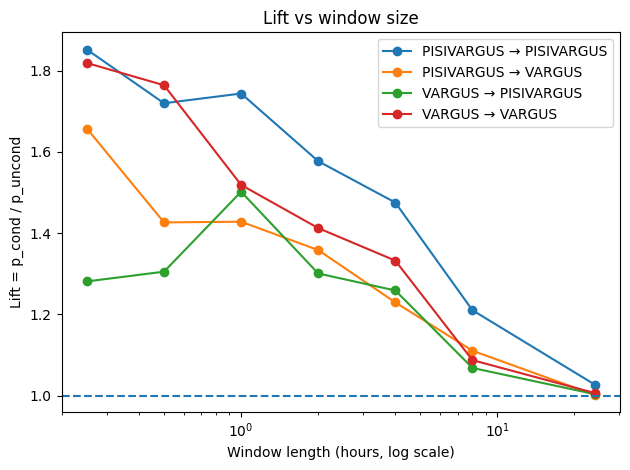

In [25]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# ============================
# SETTINGS
# ============================

windows = [
    pd.Timedelta("15min"),
    pd.Timedelta("30min"),
    pd.Timedelta("1h"),
    pd.Timedelta("2h"),
    pd.Timedelta("4h"),
    pd.Timedelta("8h"),
    pd.Timedelta("24h"),
]

# Pick a few pairs to study (edit freely)
pairs = [
    ("PISIVARGUS", "VARGUS"),
    ("VARGUS", "VARGUS"),
    ("PISIVARGUS", "PISIVARGUS"),
    ("VARGUS", "PISIVARGUS"),
]

min_events_A = 30
min_events_B = 30
M_baseline = 5000
rng = np.random.default_rng(0)

# ============================
# PREP DATA
# ============================

df = tallinn_expanded.dropna(subset=["ToimDatetime"]).copy()
df = df.sort_values("ToimDatetime")

t_min = np.datetime64(df["ToimDatetime"].min())
t_max = np.datetime64(df["ToimDatetime"].max())

# helper: get sorted times for a crime type
def get_times(crime_type: str) -> np.ndarray:
    t = df.loc[df["SyndmusLiik"] == crime_type, "ToimDatetime"].to_numpy(dtype="datetime64[ns]")
    return t

# ============================
# CORE FUNCTIONS
# ============================

def unconditional_prob(tB: np.ndarray, window_np: np.timedelta64) -> tuple[float, float]:
    """P(≥1 B in a random window of length window_np). Returns (p, se)."""
    latest_start = t_max - window_np
    if latest_start <= t_min:
        return np.nan, np.nan

    start_int = t_min.astype("datetime64[ns]").astype("int64")
    end_int = latest_start.astype("datetime64[ns]").astype("int64")

    starts = rng.integers(start_int, end_int + 1, size=M_baseline).astype("datetime64[ns]")

    left = np.searchsorted(tB, starts, side="left")
    right = np.searchsorted(tB, starts + window_np, side="right")
    hits = (right > left)

    p = hits.mean()
    se = np.sqrt(p * (1 - p) / M_baseline)
    return p, se


def conditional_prob(tA: np.ndarray, tB: np.ndarray, window_np: np.timedelta64) -> tuple[float, float, int]:
    """
    P(≥1 B in (t, t+window] | A at time t), using all A times that are not right-censored.
    Returns (p, se, n).
    """
    valid_mask = tA <= (t_max - window_np)
    tA_valid = tA[valid_mask]
    n = len(tA_valid)
    if n == 0:
        return np.nan, np.nan, 0

    left = np.searchsorted(tB, tA_valid, side="right")
    right = np.searchsorted(tB, tA_valid + window_np, side="right")
    hits = (right > left)

    p = hits.mean()
    se = np.sqrt(p * (1 - p) / n)
    return p, se, n


# ============================
# RUN ANALYSIS
# ============================

rows = []

for A, B in pairs:
    tA = get_times(A)
    tB = get_times(B)

    if len(tA) < min_events_A or len(tB) < min_events_B:
        print(f"Skipping {A}->{B} (too few events: nA={len(tA)}, nB={len(tB)})")
        continue

    for w in windows:
        w_np = np.timedelta64(w)

        p_uncond, se_uncond = unconditional_prob(tB, w_np)
        p_cond, se_cond, nA_used = conditional_prob(tA, tB, w_np)

        if not np.isfinite(p_uncond) or not np.isfinite(p_cond) or p_uncond <= 0:
            continue

        diff = p_cond - p_uncond
        se_diff = np.sqrt(se_cond**2 + se_uncond**2)
        z = diff / se_diff if se_diff > 0 else np.nan
        p_value = 2 * norm.sf(abs(z)) if np.isfinite(z) else np.nan  # stable tails

        lift = p_cond / p_uncond if p_uncond > 0 else np.nan

        rows.append({
            "A": A,
            "B": B,
            "window": str(w),
            "window_hours": w.total_seconds() / 3600,
            "p_uncond": p_uncond,
            "p_cond": p_cond,
            "lift": lift,
            "diff": diff,
            "Z": z,
            "p_value": p_value,
            "nA_used": nA_used
        })

lift_df = pd.DataFrame(rows).sort_values(["A", "B", "window_hours"])

lift_df

import matplotlib.pyplot as plt

for (A, B), sub in lift_df.groupby(["A", "B"]):
    plt.plot(sub["window_hours"], sub["lift"], marker="o", label=f"{A} → {B}")

plt.axhline(1.0, linestyle="--")
plt.xscale("log")
plt.xlabel("Window length (hours, log scale)")
plt.ylabel("Lift = p_cond / p_uncond")
plt.title("Lift vs window size")
plt.legend()
plt.tight_layout()
plt.show()